# 2. 합성곱신경망 맛보기

In [14]:
#라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms #데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
train_dataset = torchvision.datasets.FashionMNIST("/data", download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("/data", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

In [17]:
#fashion_mnist 데이터를 데이터로더에 전달
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100) #원하는 크기의 배치 단위로 데이터를 불러오거나 무작위로 섞이도록 할 수 있음
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

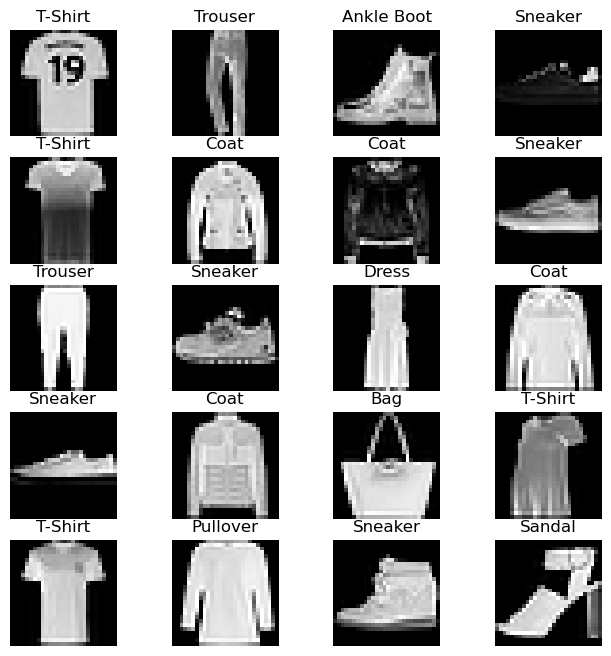

In [18]:
#분류에 사용될 클래스 정의
labels_map = {0:'T-Shirt', 1:'Trouser', 2:'Pullover',3:'Dress',4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag',9:'Ankle Boot'} #열 개의 클래스
fig=plt.figure(figsize = (8,8));
columns = 4;
rows=5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:] #3차원 배열 생성
    fig.add_subplot(rows, columns, i) #칸 생성
    plt.title(labels_map[train_dataset[img_xy][1]]) #항목이름
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()


In [19]:
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256)
        self.drop = nn.Dropout(0.25) #드롭아웃
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
    
    def forward(self, input_data): #순전파. 반드시 이름은 forward
        out = input_data.view(-1, 784) #view는 넘파이의 reshape와 같은 역할로, 텐서의 크기를 변경
        out = F.relu(self.fc1(out)) #활성화 함수 지정. F.relu()는 forward 함수에서의 정의. 근본적으로는 nn.functional.xx()와 nn.xx()의 차이.
        #nn.xx : 클래스. nn.Module 클래스를 상속받아 사용. 파라미터 새로 정의 X.
        #nn.functional.xx (F.xx) : 함수. 가중치를 수동으로 전달해야할 때마다 자체 가중치를 정의
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [20]:
#심층 신경망에서 필요한 파라미터 정의
learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss(); #분류 문제에서 사용되는 손실함수
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate); #옵티마이저를 위한 경사 하강법은 Adam을 사용하며 학습률을 의미하는 lr은 0.001 사용
print(model)


FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [10]:
#심층 신경망을 이용한 모델 학습
num_epochs = 5
count = 0

loss_list = [] #일반적으로 배열이나 행렬과 같은 리스트를 사용: 빈리스트를 만들고 append로 쌓는다
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader: #for 구문으로 레코드를 하나씩 가져옴
        images, labels = images.to(device), labels.to(device)
        
        train = Variable(images.view(100,1,28,28)) #자동미분
        labels = Variable(labels)
        
        outputs = model(train) #학습데이터를 모델에 적용
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        
        if not (count%50): #count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            
            accuracy = correct * 100 / total #정확도 계산
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
        if not (count%500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.5747459530830383, Accuracy: 83.16999816894531%
Iteration: 1000, Loss: 0.5120640993118286, Accuracy: 84.70999908447266%
Iteration: 1500, Loss: 0.3648774027824402, Accuracy: 84.4800033569336%
Iteration: 2000, Loss: 0.3129313588142395, Accuracy: 86.23999786376953%
Iteration: 2500, Loss: 0.24271059036254883, Accuracy: 86.12999725341797%
Iteration: 3000, Loss: 0.29431644082069397, Accuracy: 86.55999755859375%


In [29]:
#합성곱 네트워크 생성
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) #이미지 축소용
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0),-1) #합성곱층에서 완전연결층으로 변경되기 때문에 데이터를 1차원을 바꿈 . 행 수는 알지만 열 수는 알지 못할때 -1 사용
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [30]:
#합성곱 네트워크를 위한 파라미터 정의
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [32]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader :
        images, labels = images.to(device), labels.to(device)
        
        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)
        
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        
        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
                
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
        if not(count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count,loss.data, accuracy))

Iteration: 500, Loss: 0.4425196051597595, Accuracy: 88.01000213623047%
Iteration: 1000, Loss: 0.31318503618240356, Accuracy: 88.25%
Iteration: 1500, Loss: 0.28634941577911377, Accuracy: 88.41000366210938%
Iteration: 2000, Loss: 0.14833898842334747, Accuracy: 89.2699966430664%
Iteration: 2500, Loss: 0.14848551154136658, Accuracy: 89.72000122070312%
Iteration: 3000, Loss: 0.19130337238311768, Accuracy: 90.44000244140625%
